# 0. Module Understand

各个模块的理解

## 0.1 Window partition 和window reverse

partition顾名思义，把一张图片切片成多个小patch，比如输入图片是（64，64，3）的维度，patch边长为4，则可以切出（64//4）^2 也就是256 张图片，所以输出维度是(256, 4,4, 3)

而reverse就是逆过程

In [3]:
def window_partition(x, win_size, dilation_rate=1):
    B, H, W, C = x.shape
    if dilation_rate !=1:
        x = x.permute(0,3,1,2) # B, C, H, W
        assert type(dilation_rate) is int, 'dilation_rate should be a int'
        x = F.unfold(x, kernel_size=win_size,dilation=dilation_rate,padding=4*(dilation_rate-1),stride=win_size) # B, C*Wh*Ww, H/Wh*W/Ww
        windows = x.permute(0,2,1).contiguous().view(-1, C, win_size, win_size) # B' ,C ,Wh ,Ww
        windows = windows.permute(0,2,3,1).contiguous() # B' ,Wh ,Ww ,C
    else:
        x = x.view(B, H // win_size, win_size, W // win_size, win_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, win_size, win_size, C) # B' ,Wh ,Ww ,C
    return windows

In [4]:
import torch
test = torch.rand(1,64,64,3)
win_size = 4
output = window_partition(test, win_size)
output.shape


torch.Size([256, 4, 4, 3])

In [5]:
def window_reverse(windows, win_size, H, W, dilation_rate=1):
    # B' ,Wh ,Ww ,C
    B = int(windows.shape[0] / (H * W / win_size / win_size))
    x = windows.view(B, H // win_size, W // win_size, win_size, win_size, -1)
    if dilation_rate !=1:
        x = windows.permute(0,5,3,4,1,2).contiguous() # B, C*Wh*Ww, H/Wh*W/Ww
        x = F.fold(x, (H, W), kernel_size=win_size, dilation=dilation_rate, padding=4*(dilation_rate-1),stride=win_size)
    else:
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('./low/1.png')
import torchvision.transforms as transforms
transform = transforms.ToTensor()
x = transform(img)
x = x.unsqueeze(0)
x_input = x
x.shape

torch.Size([1, 3, 400, 600])

In [6]:
x_input = x_input.permute(0, 2, 3, 1)
windows = window_partition(x_input,50)
print(windows.shape)
plt.imshow(windows[0].detach().numpy()) 

RuntimeError: shape '[1, 12, 50, 0, 50, 400]' is invalid for input of size 720000

In [21]:
x_reverse = window_reverse(windows, 50,400, 600)
x_reverse.shape

torch.Size([1, 400, 600, 3])

TypeError: Invalid shape (3, 400, 600) for image data

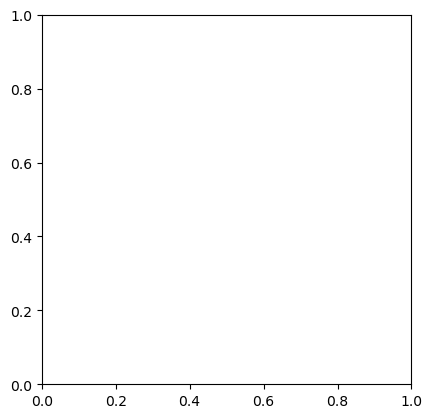

In [22]:
x_reverse =  x_reverse.permute(0, 3, 1, 2)
plt.imshow(x_reverse[0].detach().numpy())

In [12]:
import torch.nn as nn
class BasicConv_do(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, bias=False, norm=False, relu=True, transpose=False,
                 relu_method=nn.ReLU, groups=1, norm_method=nn.BatchNorm2d):
        super(BasicConv_do, self).__init__()
        if bias and norm:
            bias = False

        padding = kernel_size // 2
        layers = list()
        if transpose:
            padding = kernel_size // 2 - 1
            layers.append(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        else:
            layers.append(
                DOConv2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias, groups=groups))
        if norm:
            layers.append(norm_method(out_channel))
        if relu:
            if relu_method == nn.ReLU:
                layers.append(nn.ReLU(inplace=True))
            elif relu_method == nn.LeakyReLU:
                layers.append(nn.LeakyReLU(inplace=True))
            else:
                layers.append(relu_method())
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

main_fft = nn.Sequential(
            BasicConv_do(3*2, 64*2, kernel_size=1, stride=1, relu=True),
            BasicConv_do(64*2, 3*2, kernel_size=1, stride=1, relu=False)
        )
def fft(x):
    _, _, H, W = x.shape
    dim = 1
    y = torch.fft.rfft2(x, norm='backward')
    y_imag = y.imag
    y_real = y.real
    y_f = torch.cat([y_real, y_imag], dim=dim)
    y = main_fft(y_f)
    y_real, y_imag = torch.chunk(y, 2, dim=dim)
    y = torch.complex(y_real, y_imag)
    y = torch.fft.irfft2(y, s=(H, W), norm='backward')
    return self.main(x) + x + y

fft(x)

NameError: name 'DOConv2d' is not defined

## 0.2 LeWinTransformer


In [40]:
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import math
class LeWinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, win_size=8, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,token_projection='linear',token_mlp='leff',
                 modulator=False,cross_modulator=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.win_size = win_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.token_mlp = token_mlp
        if min(self.input_resolution) <= self.win_size:
            self.shift_size = 0
            self.win_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.win_size, "shift_size must in 0-win_size"

        if modulator:
            self.modulator = nn.Embedding(win_size*win_size, dim) # modulator
        else:
            self.modulator = None

        if cross_modulator:
            self.cross_modulator = nn.Embedding(win_size*win_size, dim) # cross_modulator
            self.cross_attn = Attention(dim,num_heads,qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
                    token_projection=token_projection,)
            self.norm_cross = norm_layer(dim)
        else:
            self.cross_modulator = None

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, win_size=to_2tuple(self.win_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            token_projection=token_projection)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        if token_mlp in ['ffn','mlp']:
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,act_layer=act_layer, drop=drop) 
        elif token_mlp=='leff':
            self.mlp =  LeFF(dim,mlp_hidden_dim,act_layer=act_layer, drop=drop)
        
        elif token_mlp=='fastleff':
            self.mlp =  FastLeFF(dim,mlp_hidden_dim,act_layer=act_layer, drop=drop)    
        else:
            raise Exception("FFN error!") 


    def with_pos_embed(self, tensor, pos):
        return tensor if pos is None else tensor + pos
        
    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"win_size={self.win_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio},modulator={self.modulator}"

    def forward(self, x, mask=None):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        
        ## input mask
        if mask != None:
            input_mask = F.interpolate(mask, size=(H,W)).permute(0,2,3,1)
            input_mask_windows = window_partition(input_mask, self.win_size) # nW, win_size, win_size, 1
            attn_mask = input_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            attn_mask = attn_mask.unsqueeze(2)*attn_mask.unsqueeze(1) # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask.masked_fill(attn_mask!=0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        ## shift mask
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            shift_mask = torch.zeros((1, H, W, 1)).type_as(x)
            h_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    shift_mask[:, h, w, :] = cnt
                    cnt += 1
            shift_mask_windows = window_partition(shift_mask, self.win_size)  # nW, win_size, win_size, 1
            shift_mask_windows = shift_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            shift_attn_mask = shift_mask_windows.unsqueeze(1) - shift_mask_windows.unsqueeze(2) # nW, win_size*win_size, win_size*win_size
            shift_attn_mask = shift_attn_mask.masked_fill(shift_attn_mask != 0, float(-100.0)).masked_fill(shift_attn_mask == 0, float(0.0))
            attn_mask = attn_mask + shift_attn_mask if attn_mask is not None else shift_attn_mask


        if self.cross_modulator is not None:
            shortcut = x
            x_cross = self.norm_cross(x)
            x_cross = self.cross_attn(x, self.cross_modulator.weight)
            x = shortcut + x_cross
    
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.win_size)  # nW*B, win_size, win_size, C  N*C->C
        x_windows = x_windows.view(-1, self.win_size * self.win_size, C)  # nW*B, win_size*win_size, C

        # with_modulator
        if self.modulator is not None:
            wmsa_in = self.with_pos_embed(x_windows,self.modulator.weight)
        else:
            wmsa_in = x_windows

        # W-MSA/SW-MSA
        attn_windows = self.attn(wmsa_in, mask=attn_mask)  # nW*B, win_size*win_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.win_size, self.win_size, C)
        shifted_x = window_reverse(attn_windows, self.win_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        del attn_mask
        return x
class WindowAttention(nn.Module):
    def __init__(self, dim, win_size,num_heads, token_projection='linear', qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.win_size = win_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * win_size[0] - 1) * (2 * win_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.win_size[0]) # [0,...,Wh-1]
        coords_w = torch.arange(self.win_size[1]) # [0,...,Ww-1]
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.win_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.win_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.win_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)
        trunc_normal_(self.relative_position_bias_table, std=.02)
            
        if token_projection =='conv':
            self.qkv = ConvProjection(dim,num_heads,dim//num_heads,bias=qkv_bias)
        elif token_projection =='linear':
            self.qkv = LinearProjection(dim,num_heads,dim//num_heads,bias=qkv_bias)
        else:
            raise Exception("Projection error!") 
        
        self.token_projection = token_projection
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, attn_kv=None, mask=None):
        B_, N, C = x.shape
        q, k, v = self.qkv(x,attn_kv)
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.win_size[0] * self.win_size[1], self.win_size[0] * self.win_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        ratio = attn.size(-1)//relative_position_bias.size(-1)
        relative_position_bias = repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)
    
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            mask = repeat(mask, 'nW m n -> nW m (n d)',d = ratio)
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N*ratio) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N*ratio)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
class LinearProjection(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0., bias=True):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.to_q = nn.Linear(dim, inner_dim, bias = bias)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = bias)
        self.dim = dim
        self.inner_dim = inner_dim

    def forward(self, x, attn_kv=None):
        B_, N, C = x.shape
        if attn_kv is not None:
            attn_kv = attn_kv.unsqueeze(0).repeat(B_,1,1)
        else:
            attn_kv = x
        N_kv = attn_kv.size(1)
        q = self.to_q(x).reshape(B_, N, 1, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        kv = self.to_kv(attn_kv).reshape(B_, N_kv, 2, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q = q[0]
        k, v = kv[0], kv[1] 
        return q,k,v

    def flops(self, q_L, kv_L=None): 
        kv_L = kv_L or q_L
        flops = q_L*self.dim*self.inner_dim+kv_L*self.dim*self.inner_dim*2
        return flops 
class LeFF(nn.Module):
    def __init__(self, dim=32, hidden_dim=128, act_layer=nn.GELU,drop = 0., use_eca=False):
        super().__init__()
        self.linear1 = nn.Sequential(nn.Linear(dim, hidden_dim),
                                act_layer())
        self.dwconv = nn.Sequential(nn.Conv2d(hidden_dim,hidden_dim,groups=hidden_dim,kernel_size=3,stride=1,padding=1),
                        act_layer())
        self.linear2 = nn.Sequential(nn.Linear(hidden_dim, dim))
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.eca = eca_layer_1d(dim) if use_eca else nn.Identity()

    def forward(self, x):
        # bs x hw x c
        bs, hw, c = x.size()
        hh = int(math.sqrt(hw))

        x = self.linear1(x)

        # spatial restore
        x = rearrange(x, ' b (h w) (c) -> b c h w ', h = hh, w = hh)
        # bs,hidden_dim,32x32

        x = self.dwconv(x)

        # flaten
        x = rearrange(x, ' b c h w -> b (h w) c', h = hh, w = hh)

        x = self.linear2(x)
        x = self.eca(x)

        return x

    def flops(self, H, W):
        flops = 0
        # fc1
        flops += H*W*self.dim*self.hidden_dim 
        # dwconv
        flops += H*W*self.hidden_dim*3*3
        # fc2
        flops += H*W*self.hidden_dim*self.dim
        print("LeFF:{%.2f}"%(flops/1e9))
        # eca 
        if hasattr(self.eca, 'flops'): 
            flops += self.eca.flops()
        return flops

In [41]:
LWT = LeWinTransformerBlock(dim = 3, input_resolution = (400, 600), num_heads = 2)
LWT(x_input[0])

RuntimeError: shape '[400, 24, 24, 3]' is invalid for input of size 720000

# 1. Pyramid Transformer



In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
import math


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., linear=False):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.linear = linear
        if self.linear:
            self.relu = nn.ReLU(inplace=True)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        if self.linear:
            x = self.relu(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1, linear=False):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.linear = linear
        self.sr_ratio = sr_ratio
        if not linear:
            if sr_ratio > 1:
                self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
                self.norm = nn.LayerNorm(dim)
        else:
            self.pool = nn.AdaptiveAvgPool2d(7)
            self.sr = nn.Conv2d(dim, dim, kernel_size=1, stride=1)
            self.norm = nn.LayerNorm(dim)
            self.act = nn.GELU()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if not self.linear:
            if self.sr_ratio > 1:
                x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
                x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
                x_ = self.norm(x_)
                kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            else:
                kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(self.pool(x_)).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            x_ = self.act(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1, linear=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio, linear=linear)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, linear=linear)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        
        assert max(patch_size) > stride, "Set larger patch_size than stride"
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // stride, img_size[1] // stride
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        print(x.shape)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        print(x.shape)
        x = self.norm(x)
        print(x.shape)
        return x, H, W


class PyramidVisionTransformerV2(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], num_stages=4, linear=False):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0

        for i in range(num_stages):
            patch_embed = OverlapPatchEmbed(img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                                            patch_size=7 if i == 0 else 3,
                                            stride=4 if i == 0 else 2,
                                            in_chans=in_chans if i == 0 else embed_dims[i - 1],
                                            embed_dim=embed_dims[i])

            block = nn.ModuleList([Block(
                dim=embed_dims[i], num_heads=num_heads[i], mlp_ratio=mlp_ratios[i], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer,
                sr_ratio=sr_ratios[i], linear=linear)
                for j in range(depths[i])])
            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"block{i + 1}", block)
            setattr(self, f"norm{i + 1}", norm)

        # classification head
        self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            block = getattr(self, f"block{i + 1}")
            norm = getattr(self, f"norm{i + 1}")
            x, H, W = patch_embed(x)
            for blk in block:
                x = blk(x, H, W)
            x = norm(x)
            if i != self.num_stages - 1:
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
def pvt_v2_b0(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b1(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b3(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b4(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b5(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2_li(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], linear=True, **kwargs)
    model.default_cfg = _cfg()

    return model

## OverlapPatchEmbedding 


输入 H, W, C, 输出 H/S, W/S, C'

LLFormer 中也用到了

In [61]:
OPE = OverlapPatchEmbed(img_size=(400, 600))
output = OPE(x_input.permute(0, 3, 1, 2))


torch.Size([1, 768, 100, 150])
torch.Size([1, 15000, 768])
torch.Size([1, 15000, 768])


In [59]:
x_input.permute(0, 3, 1, 2).shape

torch.Size([1, 3, 400, 600])

In [65]:
model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1])
y_pred = model(x_input.permute(0,3,1,2))

TypeError: unsupported operand type(s) for //: 'tuple' and 'int'

In [64]:
y_pred.shape

torch.Size([1, 1000])